In [12]:
#analyzing SNOD dataset with a counterpropagation network
#the goal is to see if we can 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#imports
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [13]:
#upload the data
df = pd.read_csv('data/input_df.csv')

In [14]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'site', 'SNOD', 'ant1d_SNOD', 'delta', 'day',
       'pai_mean', 'pai_sd', 'rumple', 'height_max', 'height_mean',
       'height_95pct', 'canopy_relief_ratio', 'entropy', 'pct_conifer',
       'ndvi_total_mean', 'ndvi_con_mean', 'vertical_gap_fraction',
       'Elevation', 'X', 'mean_temp', 'max_temp', 'min_temp', 'total_solar',
       'pressure', 'rel_humidity', 'precip', 'avg_wind_speed',
       'max_wind_speed', 'ant3d_precip', 'ant1d_mean_temp', 'ant1d_max_temp',
       'ant1d_min_temp'],
      dtype='object')


In [44]:
#split and setup features and target for model
#3-class target sourced from delta(change in snow depth day over day)
# 1 = increase, 2 = decrease, 3 = no change
threshold = 1e-6    #handles negligible changes in snow depth
y = pd.Series(3, index=df.index)    #default - no change
y[df['delta'] > threshold] = 1  #1 - increase
y[df['delta'] < -threshold] = 2 #2 - decrease
y = y.astype(int)

#now select numeric features and drop identifiers for features
X = df.drop(columns=['Unnamed: 0', 'date', 'site', 'SNOD', 'ant1d_SNOD', 'delta'])
# X = df.drop(columns=['Unnamed: 0', 'date', 'site', 'delta'])

#already cleaned

In [45]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [46]:
# instantiate and train MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu',
                    solver='adam', max_iter=1000, early_stopping=True,
                    random_state=42)
mlp.fit(X_train_scaled, y_train)

,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [47]:
# labels -> human readable names (matches 1,2,3)
target_labels = [1, 2, 3]
target_names = ['increase', 'decrease', 'no_change']

# predict and evaluate
y_pred = mlp.predict(X_test_scaled)
# metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, labels=target_labels, target_names=target_names, digits=4)
cm = confusion_matrix(y_test, y_pred, labels=target_labels)

Accuracy: 0.6076
Classification report:
              precision    recall  f1-score   support

    increase     0.5899    0.4881    0.5342       336
    decrease     0.6485    0.8209    0.7246       508
   no_change     0.3960    0.2247    0.2867       178

    accuracy                         0.6076      1022
   macro avg     0.5448    0.5112    0.5152      1022
weighted avg     0.5853    0.6076    0.5857      1022



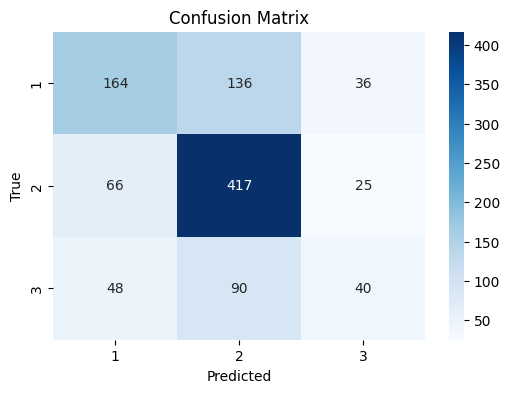

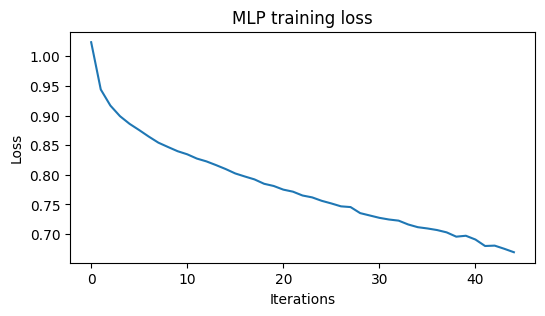

In [48]:
print(f'Accuracy: {acc:.4f}')
print('Classification report:')
print(report)

# plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# optional: training loss curve
plt.figure(figsize=(6,3))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP training loss')
plt.show()

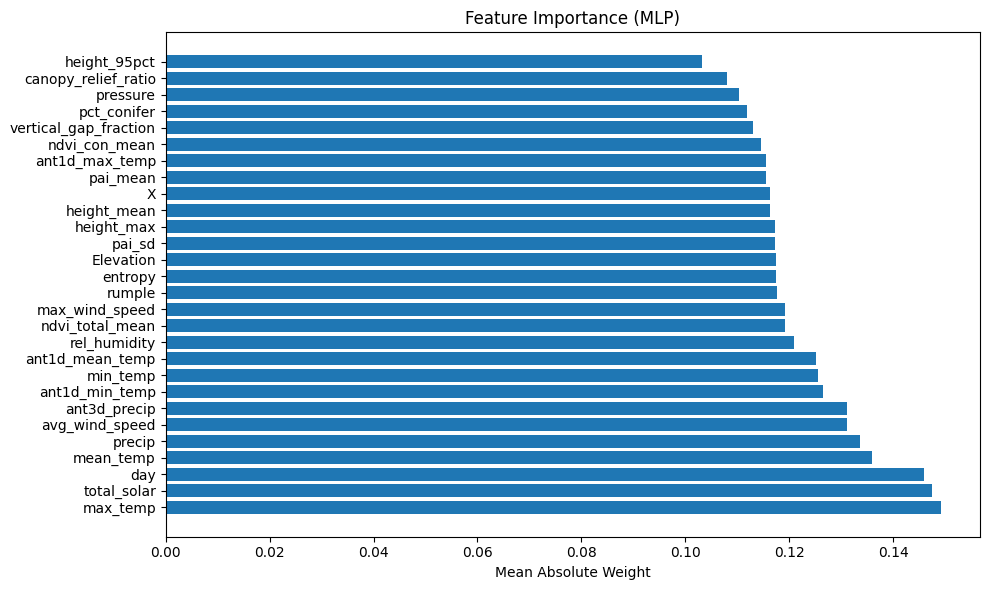

Top 10 Important Features:
1. max_temp: 0.1493
2. total_solar: 0.1476
3. day: 0.1459
4. mean_temp: 0.1359
5. precip: 0.1336
6. avg_wind_speed: 0.1312
7. ant3d_precip: 0.1311
8. ant1d_min_temp: 0.1265
9. min_temp: 0.1256
10. ant1d_mean_temp: 0.1251


In [49]:
# New cell: feature importance analysis
feature_importance = np.abs(mlp.coefs_[0]).mean(axis=1)
feature_names = X.columns

# sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Mean Absolute Weight')
plt.title('Feature Importance (MLP)')
plt.tight_layout()
plt.show()

# print top features
print('Top 10 Important Features:')
for i, idx in enumerate(sorted_idx[:10]):
    print(f'{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}')

When using SNOD and ant1SNOD as features:
- prediction is much more accurate

When not usig them:
- prediction is much less accurate